In [1]:
from pathlib import Path
import pandas as pd 
import numpy as np
# %matplotlib widget #uncomment this to zoom in at figures
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

# Local modules
import time_difference
import well_corrections
import closure_analysis
import plotting



# ----------------------------
# File paths (cross-platform)
# ----------------------------
base = Path("Data") / "Amstelland"

SURF_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Cementing Unit_Data.txt"
DOWN_PATH = base / "NLOG_GS_PUB_AMS-01_XLOT 1 - Main Claystone_Downhole Gauge_Data.TXT"

CAP_S = 210            # analyze/plot max 3.5 minutes

# ----------------------------
# Helpers
# ----------------------------
def to_num(series):
    """
    Normalize numeric text: strip whitespace, remove NBSPs, comma→dot, coerce to float.
    Returns a pandas Series[float].
    """
    s = pd.Series(series, copy=False)
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce")
    s = s.astype(str).str.strip()
    s = s.str.replace('\u00A0', '', regex=False)   # NBSP
    s = s.str.replace(',', '.', regex=False)       # decimal comma -> dot
    s = s.replace({'': None})
    return pd.to_numeric(s, errors='coerce')

def get_or_nan(df, col):
    """Return numeric series for existing column or a NaN series matching df length."""
    if col in df.columns:
        return to_num(df[col])
    return pd.Series([np.nan] * len(df), index=df.index, dtype=float)


# ----------------------------
# Example usage
# ----------------------------
dfS = pd.read_csv(SURF_PATH, sep="\t", engine="python", on_bad_lines="skip")
dfD = pd.read_csv(DOWN_PATH, sep="\t", engine="python", on_bad_lines="skip")

print("Surface data file loaded:", SURF_PATH.resolve())
print("Downhole data file loaded:", DOWN_PATH.resolve())

# Ensure expected columns exist for downhole file
dfD.columns = ['Time', 'Delta Time', 'Pressure', 'Temperature', 'None', 'None2']

# Slice away headers/units lines typical of these exports
dfS = dfS.iloc[1:].reset_index(drop=True)
dfD = dfD.iloc[4:, :-2].reset_index(drop=True)  # drop last two 'None' cols

# ----------------------------
# Parse time columns
# ----------------------------
# Surface time format: %m:%d:%Y:%H:%M:%S
time_surface = pd.to_datetime(dfS['Time'], format='%m:%d:%Y:%H:%M:%S', errors='coerce')

# Downhole time format: %d-%m-%Y %H:%M:%S
time_downhole = pd.to_datetime(dfD['Time'].astype(str).str.strip(),
                               format='%d-%m-%Y %H:%M:%S', errors='coerce')

# ----------------------------
# Numeric columns (Surface)
# ----------------------------
pressure_S          = get_or_nan(dfS, 'Treating Pressure')
flowrate_S          = get_or_nan(dfS, 'Flow Rate') * 0.06 # l/min -> m³/hour
density_S           = get_or_nan(dfS, 'Density')
volume_S            = get_or_nan(dfS, 'Volume')
tot_volume_nrd_S    = get_or_nan(dfS, 'TOT vol nrd')
volume_nrd_S        = get_or_nan(dfS, 'NRD VOLUME')
return_volume_S     = get_or_nan(dfS, 'RETURN VOL')
totbalance_volume_S = get_or_nan(dfS, 'total bla')  # may not exist in some files
RDA_pressure_S      = get_or_nan(dfS, 'RDA2 IN1')

# ----------------------------
# Numeric columns (Downhole)
# ----------------------------
delta_time_D  = to_num(dfD['Delta Time'])
pressure_D    = to_num(dfD['Pressure']) * 0.0689476  # psi -> bar
temperature_D = to_num(dfD['Temperature'])

# ----------------------------
# Time windows
# ----------------------------
startS = pd.to_datetime("2023-12-10 15:15:00")
endS   = pd.to_datetime("2023-12-10 17:30:00")

startD = pd.to_datetime("2023-12-10 14:15:00")
endD   = pd.to_datetime("2023-12-10 16:30:00")

# ----------------------------
# Masks (NaN-safe)
# ----------------------------
maskS = (
    pressure_S.notna() &
    time_surface.notna() &
    (RDA_pressure_S.fillna(np.inf) <= 2000) &
    (time_surface >= startS) & (time_surface <= endS)
)

time_S               = time_surface[maskS]
pressure_S           = pressure_S[maskS]
flowrate_S           = flowrate_S[maskS]
density_S            = density_S[maskS]
volume_S             = volume_S[maskS]
tot_volume_nrd_S     = tot_volume_nrd_S[maskS]
volume_nrd_S         = volume_nrd_S[maskS]
return_volume_S      = return_volume_S[maskS]
totbalance_volume_S  = totbalance_volume_S[maskS]
RDA_pressure_S       = RDA_pressure_S[maskS]

print('surface time min/max:', (time_surface.min(), time_surface.max()))

maskD = (
    time_downhole.notna() &
    pressure_D.notna() &
    temperature_D.notna() &
    (time_downhole >= startD) & (time_downhole <= endD)
)

time_D        = time_downhole[maskD]
delta_time_D  = delta_time_D[maskD]
pressure_D    = pressure_D[maskD]
temperature_D = temperature_D[maskD]

print('downhole time min/max:', (time_downhole.min(), time_downhole.max()))

# ----------------------------
# Surface panels
# ----------------------------
fig1, axs1 = plotting.plot_surface_panels(
    time_S, pressure_S, flowrate_S, density_S, volume_S,
    tot_volume_nrd_S, return_volume_S, totbalance_volume_S, RDA_pressure_S,
    figsize=(22, 8), markersize=0.2, linewidth=1.0, tick_labelsize=7, title_labelsize=6
)

# ----------------------------
# Triple-axis (surface subset)
# ----------------------------
fig2, (ax1, ax2, ax3) = plotting.plot_triple_axis(
    time_S, pressure_S, flowrate_S, return_volume_S,
    start=startS, end=endS, figsize=(16, 6)
)

# --- Simple shut-in lines on Figure 2 (plot_triple_axis) ---

q_thresh = 0.2  # m³/h threshold for "pumping" vs "shut-in"

is_pumping = (flowrate_S.fillna(0.0) > q_thresh)
shut_in_mask = is_pumping.shift(1, fill_value=False) & (~is_pumping)
shut_in_times = pd.to_datetime(time_S[shut_in_mask])

for ts in shut_in_times:
    for ax in (ax1, ax2, ax3):
        ax.axvline(ts, color="k", linestyle="--", linewidth=1.2, alpha=0.9)

# Add legend entry (optional)
if len(shut_in_times) > 0:
    ax1.axvline(shut_in_times.iloc[0], color="k", linestyle="--", linewidth=1.2, alpha=0.9, label="Shut-in")
    for ax in (ax1, ax2, ax3):
        h, l = ax.get_legend_handles_labels()
        if l:
            ax.legend(h, l, loc="best", fontsize=8)


# ----------------------------
# Downhole P/T plot
# ----------------------------
fig3, (ax4, ax5) = plotting.plot_downhole_pt(time_D, pressure_D, temperature_D, figsize=(16, 6))

# ----------------------------
# Depths & lag estimation
# ----------------------------
# Example MD/TVD arrays; replace with real values
MD = np.array([1364, 1383, 1383.3], dtype=float)
TVD = np.array([1363.18, np.nan, 1382.31], dtype=float)  # NaN = missing value
TVD_fracture_m = 1866.50
gauge_index    = 1  # index of the downhole gauge in the MD/TVD arrays

# Surface gauge is x m ABOVE TVD=0  → TVD_surface_sensor_m = -x (down is +)
TVD_surface_sensor_m = -1.46
delta_tvd_surface_to_frac = TVD_fracture_m - TVD_surface_sensor_m  # = TVD_fracture_m + 1.46


# NOTE: we use the (MD, TVD, gauge_index, TVD_fracture_m) signature per the fixed helper
TVD_interp, TVD_gauge_m, delta_tvd_m = well_corrections.estimate_lag(MD, TVD, gauge_index, TVD_fracture_m)

# Estimate delay (surface vs downhole)
try:
    lag_s, grid_step = time_difference.estimate_delay_seconds_robust(
        time_S, pressure_S,
        time_D, pressure_D,
        max_lag_s=4*3600,    # 4 hours
        detrend_window_s=120
    )
except Exception as e:
    print("Delay estimation failed; defaulting lag_s=0. Reason:", e)
    lag_s = 0.0
print(f"Estimated delay: {float(lag_s)/3600:.2f} h")
# To align SURFACE to DOWNHOLE we shift SURFACE by **-lag_s**.

# ----------------------------
# Hydrostatic corrections to fracture depth
# ----------------------------
# Surface pressure corrected to fracture (if surface sensor is at TVD≈0, ΔTVD≈TVD_fracture_m)
p_surface_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_S,      # SURFACE treating pressure [bar]
    time_gauge=time_S,
    rho_surface=density_S,   # surface density series
    time_surface=time_S,
    delta_tvd_m=delta_tvd_surface_to_frac,  # surface(0) -> fracture
    out_units='bar',
    lag_s=None
)

# Downhole gauge corrected to fracture
p_downhole_corr, _ = well_corrections.hydrostatic_correct_to_fracture(
    p_gauge=pressure_D,      # DOWNHOLE gauge [bar]
    time_gauge=time_D,
    rho_surface=density_S,   # use surface density aligned to DH via lag_s
    time_surface=time_S,
    delta_tvd_m=delta_tvd_m, # TVD_fracture - TVD_gauge
    out_units='bar',
    lag_s=lag_s
)

# ----------------------------
# Build aligned timelines (DOWNHOLE clock)
# ----------------------------
surface_dt_orig  = pd.to_datetime(time_S)
downhole_dt_orig = pd.to_datetime(time_D)

# Shift SURFACE timestamps by **-lag_s** to align onto DOWNHOLE clock
surface_dt_aligned_to_dh = surface_dt_orig - pd.to_timedelta(float(lag_s), unit='s')

y_surface  = pd.Series(p_surface_corr, copy=False).astype(float).to_numpy()
y_downhole = pd.Series(p_downhole_corr, copy=False).astype(float).to_numpy()

# Plot alignment (datetime)
figA, axA = plotting.plot_alignment(surface_dt_aligned_to_dh, y_surface, downhole_dt_orig, y_downhole, figsize=(16, 6))



ImportError: attempted relative import with no known parent package

In [ ]:
print('surfac first datapoint:', y_surface[0])
print('downhole first datapoint: ', y_downhole[0])


surfac first datapoint: 199.67088628059997
downhole first datapoint:  199.834619586443


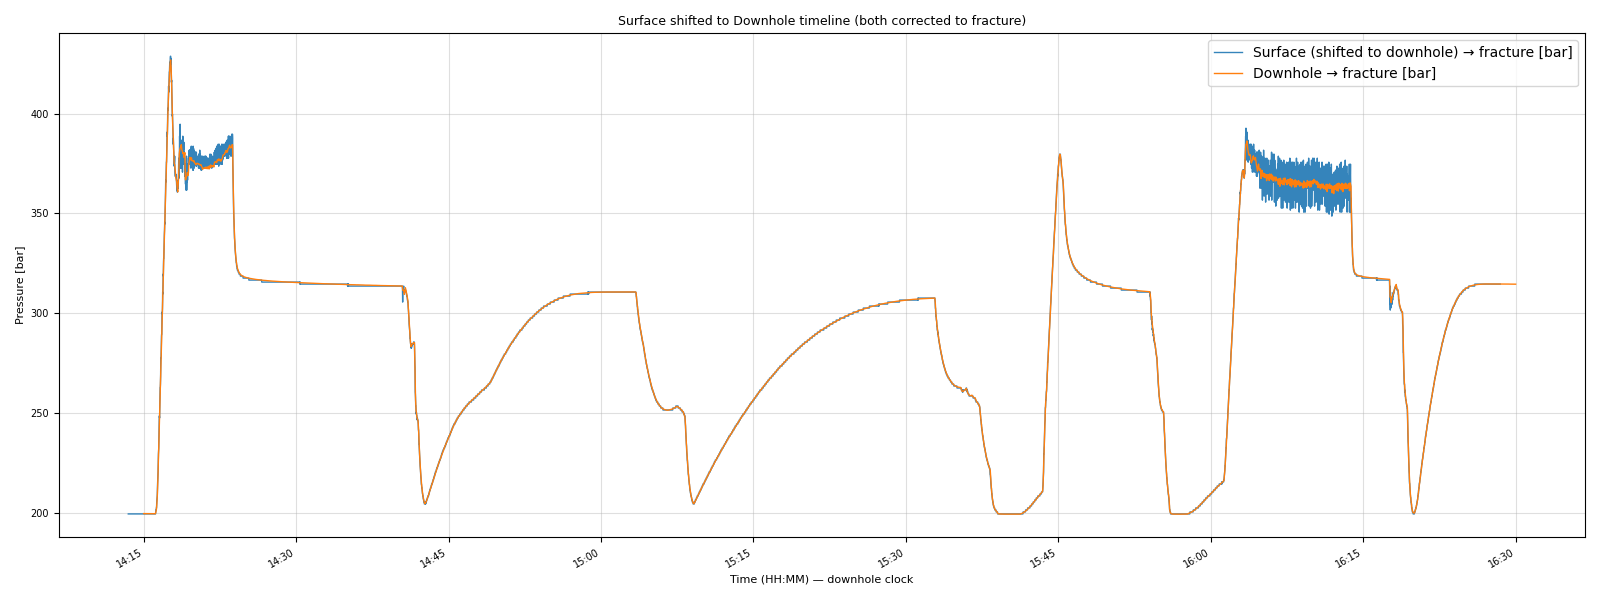

In [ ]:
# --- Simple shut-in lines on Figure 2 (plot_triple_axis) ---

q_thresh = 0.2  # m³/h threshold for "pumping" vs "shut-in" (adjust if needed)

# Boolean: pumping when flow > threshold
is_pumping = (flowrate_S.fillna(0.0) > q_thresh)

# Falling edges: transitions from pumping -> not pumping
shut_in_mask = is_pumping.shift(1, fill_value=False) & (~is_pumping)
shut_in_times = pd.to_datetime(time_S[shut_in_mask])

# Draw vertical dashed black lines on all three axes of Figure 2
for ts in shut_in_times:
    for ax in (ax1, ax2, ax3):
        ax.axvline(ts, color="k", linestyle="--", linewidth=1.2, alpha=0.9)

# (Optional) one legend entry for shut-ins
if len(shut_in_times) > 0:
    ax1.axvline(shut_in_times.iloc[0], color="k", linestyle="--", linewidth=1.2, alpha=0.9, label="Shut-in")
    for ax in (ax1, ax2, ax3):
        h, l = ax.get_legend_handles_labels()
        if l:
            ax.legend(h, l, loc="best", fontsize=8)

plt.show()

C_well ≈ 0.50 liters/bar


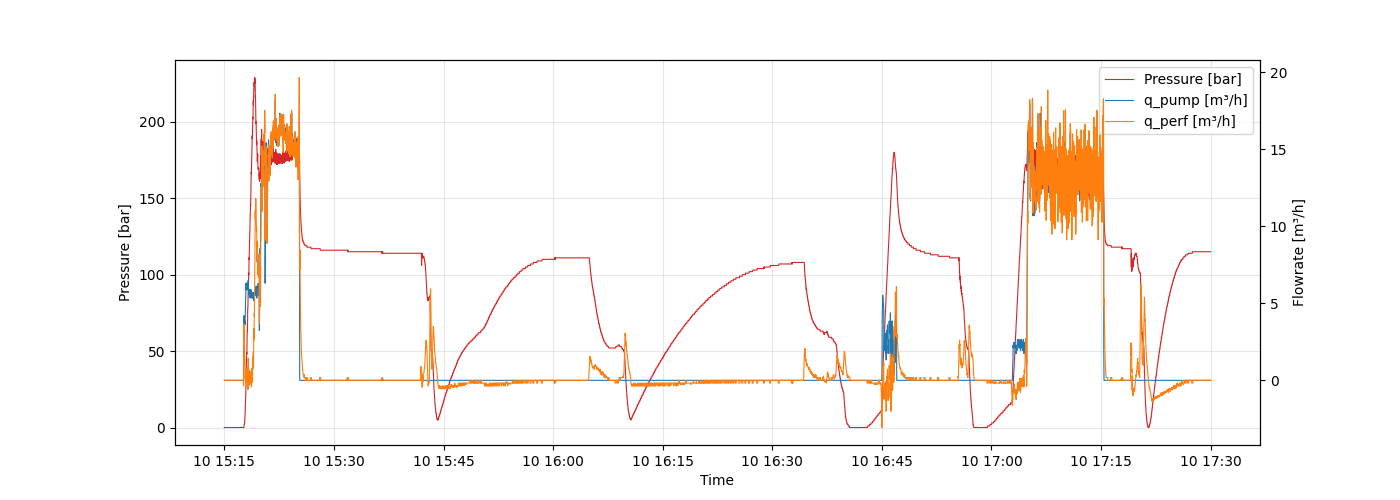

In [ ]:

# --- Pack surface data ---
df = pd.DataFrame({
    "time": pd.to_datetime(time_S),
    "P_bar": pd.to_numeric(pressure_S, errors="coerce"),
    "V_m3":  pd.to_numeric(volume_S,   errors="coerce"),
    "q_m3h": pd.to_numeric(flowrate_S, errors="coerce"),
}).dropna().sort_values("time").reset_index(drop=True)

time_s = df["time"]
P = df["P_bar"].to_numpy()
V = df["V_m3"].to_numpy()
q_pump_m3h = df["q_m3h"].to_numpy()

# --- Choose an early linear PV segment (adjust slice as needed) ---
i0, i1 = 200, 600   # pick indices in the pre-breakdown pumping ramp
coeffs = np.polyfit(P[i0:i1], V[i0:i1], 1)
C_well = coeffs[0]   # slope dV/dP [m³/bar]
C_well = 0.0005

print(f"C_well ≈ {C_well*1e3:.2f} liters/bar")

# --- Compute dP/dt ---
ts = (time_s - time_s.iloc[0]).dt.total_seconds().to_numpy()
P_smooth = pd.Series(P, index=time_s).rolling("10s", center=True, min_periods=1).mean().to_numpy()
dPdt = np.gradient(P_smooth, ts)   # [bar/s]

# --- q_perf = q_pump - C_well * dP/dt ---
q_pump_m3s = q_pump_m3h / 3600.0
q_perf_m3s = q_pump_m3s - C_well * dPdt
q_perf_m3h = q_perf_m3s * 3600.0

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(14,5))
ax1.plot(time_s, P, label="Pressure [bar]", color="C3", lw=0.8)
ax1.set_ylabel("Pressure [bar]")
ax1.set_xlabel("Time")
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(time_s, q_pump_m3h, label="q_pump [m³/h]", color="C0", lw=0.8)
ax2.plot(time_s, q_perf_m3h, label="q_perf [m³/h]", color="C1", lw=0.8)
ax2.set_ylabel("Flowrate [m³/h]")
#ax2.set_ylim(bottom=-10)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
plt.show()

C_well ≈ 1.997332e-03 m³/bar  (1.997 L/bar),  R² ≈ 0.0057


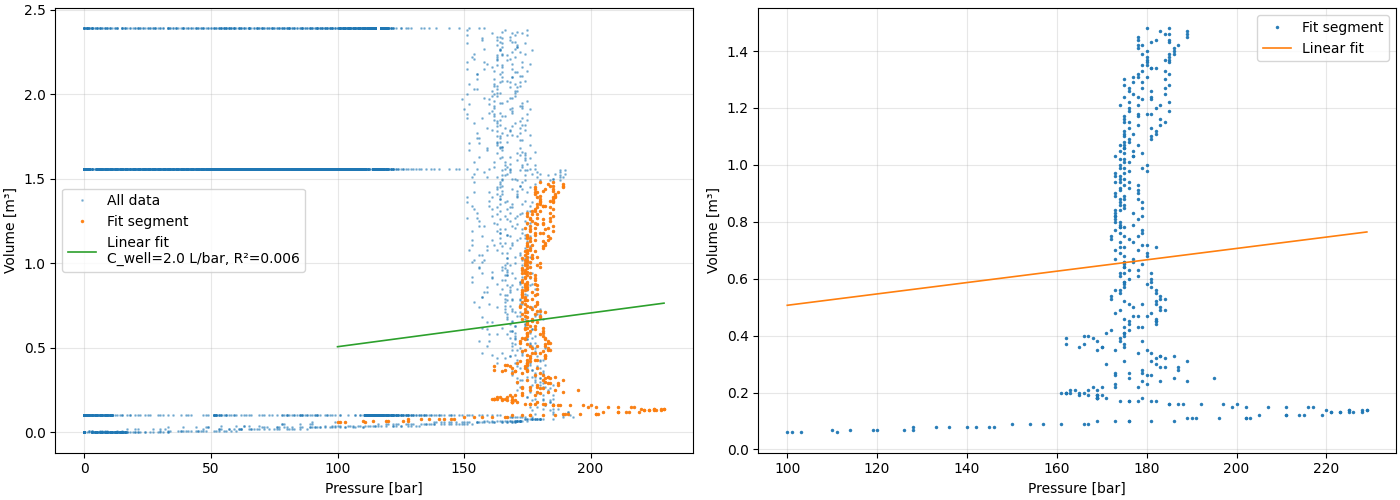

In [ ]:
# --- Pack data (pressure vs volume) ---
dfPV = pd.DataFrame({
    "P_bar": pd.to_numeric(pressure_S, errors="coerce"),
    "V_m3":  pd.to_numeric(volume_S,   errors="coerce"),
}).dropna().reset_index(drop=True)

P = dfPV["P_bar"].to_numpy()
V = dfPV["V_m3"].to_numpy()

# --- Choose a linear pre-breakdown window (edit these) ---
i0, i1 = 200, 600              # <-- set to your linear ramp indices
assert 0 <= i0 < i1 <= len(P), "i0/i1 out of range for PV arrays"

P_fit = P[i0:i1]
V_fit = V[i0:i1]

# --- Linear fit: V = a + C_well * P ---
C_well, a = np.polyfit(P_fit, V_fit, 1)   # slope, intercept (np.polyfit returns [slope, intercept] for x=P, y=V)

# R^2
V_pred = C_well * P_fit + a
ss_res = np.sum((V_fit - V_pred)**2)
ss_tot = np.sum((V_fit - V_fit.mean())**2)
R2 = 1 - ss_res/ss_tot if ss_tot > 0 else np.nan

print(f"C_well ≈ {C_well:.6e} m³/bar  ({C_well*1e3:.3f} L/bar),  R² ≈ {R2:.4f}")

# --- Build a smooth line over the fitted P-range ---
P_line = np.linspace(P_fit.min(), P_fit.max(), 200)
V_line = a + C_well * P_line

# --- Plot: full PV + zoom around the fit window ---
fig, (ax_full, ax_zoom) = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# FULL VIEW
ax_full.plot(P, V, ".", ms=2, alpha=0.4, label="All data")
ax_full.plot(P_fit, V_fit, ".", ms=3, alpha=0.9, label="Fit segment")
ax_full.plot(P_line, V_line, "-", lw=1.2, label=f"Linear fit\nC_well={C_well*1e3:.1f} L/bar, R²={R2:.3f}")
ax_full.set_xlabel("Pressure [bar]")
ax_full.set_ylabel("Volume [m³]")
ax_full.grid(True, alpha=0.3)
ax_full.legend(loc="best")

# ZOOM VIEW (tight around the segment)
pad_P = max(1.0, 0.05*(P_fit.max()-P_fit.min()))   # ~5% or ≥1 bar
pad_V = max(0.001, 0.05*(V_fit.max()-V_fit.min())) # ~5% or ≥0.001 m³

ax_zoom.plot(P_fit, V_fit, ".", ms=3, alpha=0.9, label="Fit segment")
ax_zoom.plot(P_line, V_line, "-", lw=1.2, label="Linear fit")
ax_zoom.set_xlim(P_fit.min()-pad_P, P_fit.max()+pad_P)
ax_zoom.set_ylim(V_fit.min()-pad_V, V_fit.max()+pad_V)
ax_zoom.set_xlabel("Pressure [bar]")
ax_zoom.set_ylabel("Volume [m³]")
ax_zoom.grid(True, alpha=0.3)
ax_zoom.legend(loc="best")

plt.show()

In [ ]:
# ----------------------------
# MULTI-CYCLE: detect all pump-in → shut-in cycles (surface clock)
# and cut each falloff at (pump restart | flow-back start | end of data)
# ----------------------------
q_low, q_high = closure_analysis.suggest_flow_thresholds(flowrate_S)

cycles = closure_analysis.detect_pump_cycles(
    time_S=time_S,
    q_m3h=flowrate_S,
    return_vol_S=return_volume_S,   # pass None if not available
    q_low=0.1, q_high=0.3,
    min_hold_s=30,
    min_gap_s=60,
    flowback_rate_thresh=0.2
)
print(f"Detected {len(cycles)} cycles.")

df_cycles = closure_analysis.analyze_all_shutins(
    cycles,
    time_S=time_S, flowrate_S=flowrate_S, return_volume_S=return_volume_S,
    time_D=time_D, p_downhole_corr=p_downhole_corr,
    lag_s=lag_s,
    min_falloff_s=10,
    min_t_s_for_pick=0,
    max_analysis_s=180,
    pick_from="bourdet"   # <--- use Bourdet min
)

print("\nSummary table:")
print(df_cycles)

out_path = Path("per_cycle_closure.csv")
#df_cycles.to_csv(out_path, index=False)
print(f"Saved per-cycle results to: {out_path.resolve()}")

Detected 3 cycles.

Summary table:
   cycle t_pump_start_surface   t_shut_in_surface       t_end_surface  \
0      1  2023-12-10 15:17:39 2023-12-10 15:25:20 2023-12-10 16:45:00   
1      2  2023-12-10 16:45:00 2023-12-10 16:47:02 2023-12-10 17:02:53   
2      3  2023-12-10 17:02:53 2023-12-10 17:15:24 2023-12-10 17:30:00   

  ended_by  usable  closure_time_s  closure_pressure_bar  analysis_window_s  \
0  restart    True            11.0            337.601646              180.0   
1  restart    True            23.0            336.811093              180.0   
2      end    True             7.0            330.248109              180.0   

    picker  
0  bourdet  
1  bourdet  
2  bourdet  
Saved per-cycle results to: /Users/william/Desktop/Thesis-AES/per_cycle_closure.csv



Per-cycle closure analysis (√t & G-function within 0–180 s):
  Cycle 1: FCP (√t)      ≈ 344.25 bar at t ≈ 5 s (ended by restart, window 210s)
            FCP (G-func)  ≈ 332.69 bar at t ≈ 11 s (tp=461s)
            FCP (√t inters.) ≈ 318.43 bar at t ≈ 25 s
            FCP (G inters.)  ≈ 317.69 bar at t ≈ 19 s (tp=461s)
  Cycle 2: FCP (√t)      ≈ 348.13 bar at t ≈ 8 s (ended by restart, window 210s)
            FCP (G-func)  ≈ 338.95 bar at t ≈ 17 s (tp=122s)
            FCP (√t inters.) ≈ 320.79 bar at t ≈ 54 s
            FCP (G inters.)  ≈ 319.52 bar at t ≈ 24 s (tp=122s)
  Cycle 3: FCP (√t)      ≈ 330.25 bar at t ≈ 4 s (ended by end, window 210s)
            FCP (G-func)  ≈ 325.59 bar at t ≈ 7 s (tp=751s)
            FCP (√t inters.) ≈ 318.94 bar at t ≈ 18 s
            FCP (G inters.)  ≈ 318.25 bar at t ≈ 16 s (tp=751s)


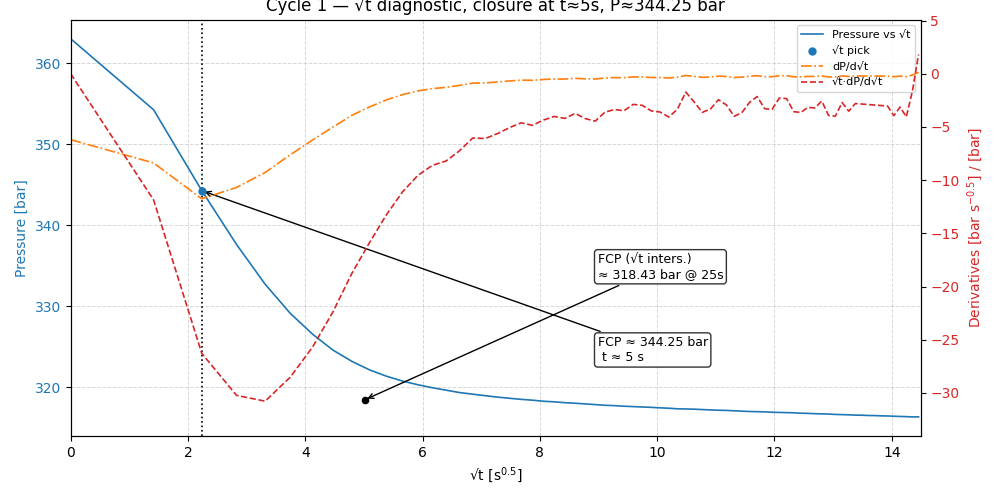

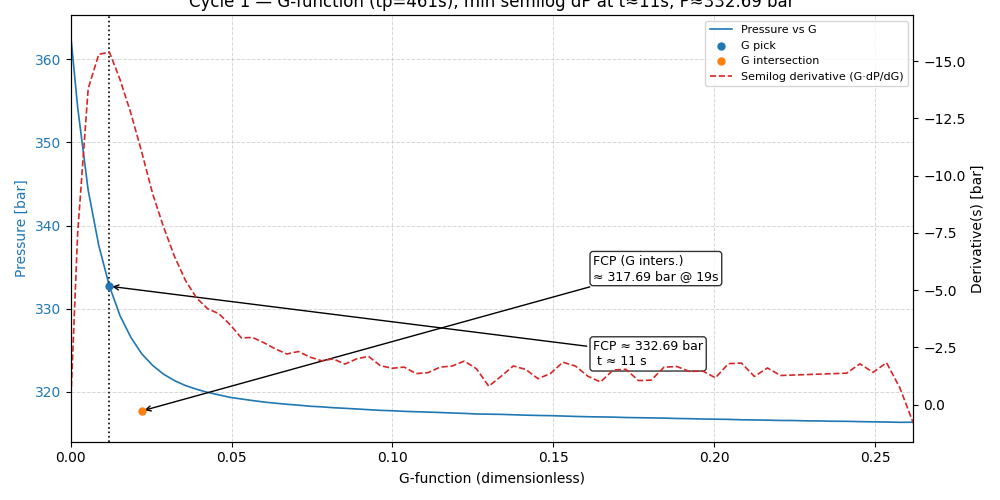

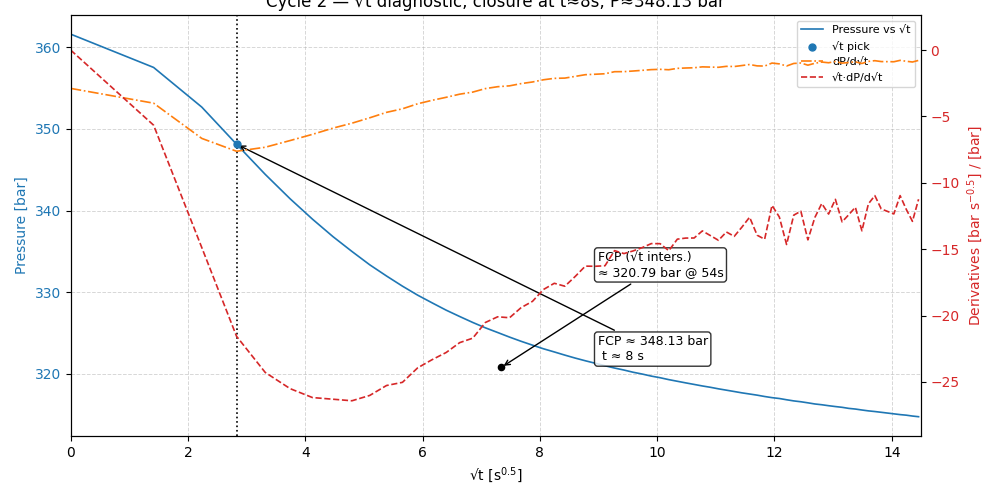

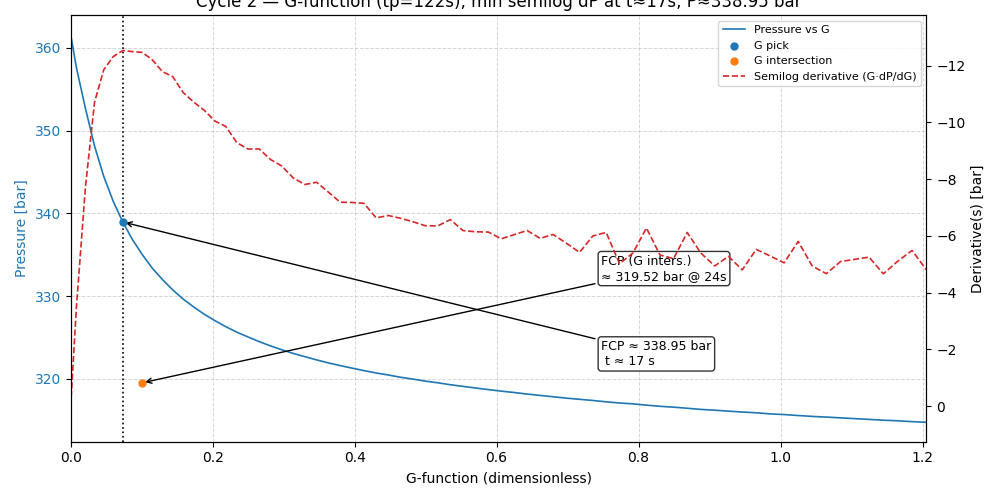

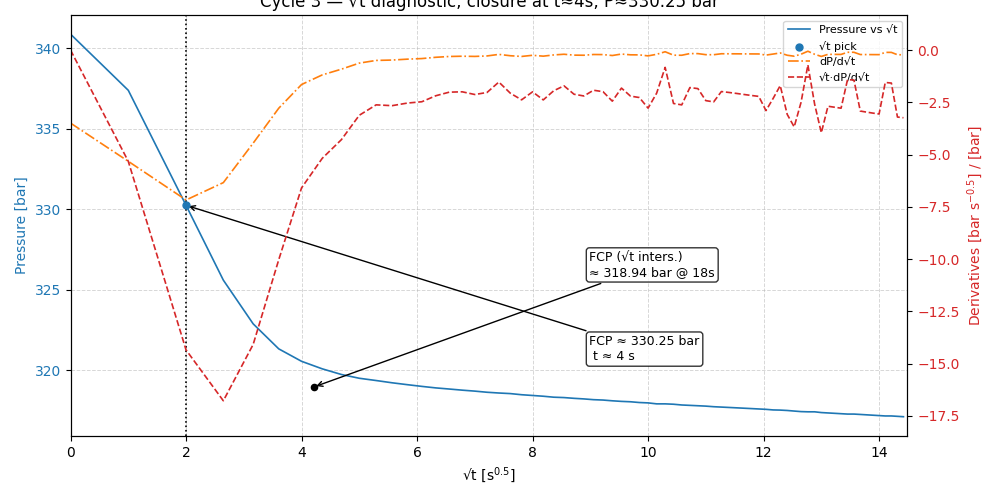

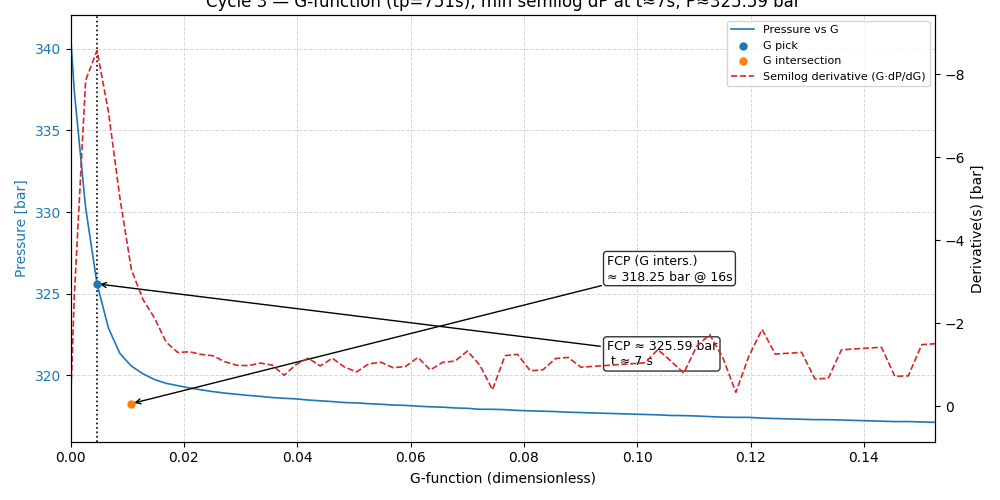

In [ ]:
# ----------------------------
# PER-CYCLE diagnostics & plots (for every detected cycle)
# ----------------------------
MIN_T_S_FOR_PICK = 0   # e.g., set to 90 to ignore the first 90 s

if len(cycles) == 0:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (√t & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # Convert cycle window to DOWNHOLE clock
        t_shut_D = cyc['t_shut_in_surface'] - pd.to_timedelta(float(lag_s), unit='s')
        t_end_D  = cyc['t_end_surface']      - pd.to_timedelta(float(lag_s), unit='s')

        # Build + cap falloff series
        ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_downhole_corr, t_shut_D)
        t_end_rel   = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
        t_hard_cap  = min(float(t_end_rel), float(CAP_S))
        keep        = (ts_dh <= t_hard_cap)
        ts_dh, p_dh = ts_dh[keep], p_dh[keep]

        # Require some usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            continue

        # --- √t diagnostic (QC) ---
        x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(
            ts_dh, p_dh, max_t_s=CAP_S
        )
        i_srt = closure_analysis.suggest_closure_from_srt(
            x_sqrt, p_srt, dpdx, min_t_s=MIN_T_S_FOR_PICK, max_t_s=CAP_S
        )

        figSRT, (ax_left_srt, ax_right_srt) = plotting.plot_srt(
            x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=CAP_S
        )

        # Title + annotation for √t pick
        if i_srt is not None and 0 <= i_srt < len(x_sqrt) and i_srt < len(p_srt):
            t_cl_srt = float(x_sqrt[i_srt] ** 2)
            p_cl_srt = float(p_srt[i_srt])
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, closure at t≈{t_cl_srt:.0f}s, P≈{p_cl_srt:.2f} bar"
            )
            ax_left_srt.scatter([x_sqrt[i_srt]], [p_cl_srt], s=25, zorder=5, label="√t pick")
            ax_left_srt.annotate(
                f"FCP ≈ {p_cl_srt:.2f} bar\n t ≈ {t_cl_srt:.0f} s",
                xy=(x_sqrt[i_srt], p_cl_srt),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )
        else:
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, no closure in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # ===========================
        # √t INTERSECTION METHOD + overlay
        # ===========================
        try:
            res_srt = closure_analysis.fcp_by_sqrt_intersection(
                ts_dh, p_dh, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_srt = {"ok": False}

        if res_srt.get("ok"):
            # numeric result
            try:
                cp_bar = float(res_srt.get("closure_pressure_bar"))
                ct_s   = float(res_srt.get("closure_time_s"))
            except Exception:
                cp_bar, ct_s = (np.nan, np.nan)

            # fits
            left_fit  = res_srt.get("left_fit",  (None, None))
            right_fit = res_srt.get("right_fit", (None, None))
            try:
                mL, bL = (float(left_fit[0]), float(left_fit[1]))
            except Exception:
                mL, bL = (np.nan, np.nan)
            try:
                mR, bR = (float(right_fit[0]), float(right_fit[1]))
            except Exception:
                mR, bR = (np.nan, np.nan)

            # split domain at closure (√t)
            if np.isfinite(ct_s) and ct_s >= 0:
                x_cl = np.sqrt(ct_s)
                xL = x_sqrt[x_sqrt <= x_cl]
                xR = x_sqrt[x_sqrt >= x_cl]
            else:
                x_cl = np.nan
                xL, xR = x_sqrt, x_sqrt

            # overlays
            if np.isfinite(mL) and np.isfinite(bL) and len(xL) > 1:
                ax_left_srt.plot(xL, mL * xL + bL, ls="--", lw=1.2, c="k", label="√t left fit")
            if np.isfinite(mR) and np.isfinite(bR) and len(xR) > 1:
                ax_left_srt.plot(xR, mR * xR + bR, ls="--", lw=1.2, c="k", label="√t right fit")

            if np.isfinite(x_cl) and np.isfinite(cp_bar):
                ax_left_srt.scatter([x_cl], [cp_bar], s=20, c="k", zorder=5)
                ax_left_srt.annotate(
                    f"FCP (√t inters.)\n≈ {cp_bar:.2f} bar @ {ct_s:.0f}s",
                    xy=(x_cl, cp_bar),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

            # legend combine (left+right)
            h1, l1 = ax_left_srt.get_legend_handles_labels()
            h2, l2 = ax_right_srt.get_legend_handles_labels()
            ax_left_srt.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # --- G-function diagnostic (Barree/Nolte) ---
        try:
            tp_s = (cyc['t_shut_in_surface'] - cyc['t_pump_start_surface']).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)  # safe fallback

        G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
        semilog_dP = closure_analysis.semilog_derivative(G, p_dh)
        i_g = None
        if len(G) >= 3 and np.isfinite(semilog_dP).any():
            mwin = (
                (ts_dh >= float(MIN_T_S_FOR_PICK)) &
                (ts_dh <= float(CAP_S)) &
                np.isfinite(semilog_dP)
            )
            if mwin.any():
                idx = np.where(mwin)[0]
                i_g = idx[np.nanargmin(semilog_dP[idx])]

        figG, (axG_left, axG_right) = plotting.plot_gfunction(
            ts_seconds=ts_dh,
            p=p_dh,
            tp_seconds=tp_s,
            p_times=ts_dh,
            i_cl=i_g,
            cap_s=CAP_S,
            plot_normal=False
        )

        # Title + annotation for G pick
        if i_g is not None and 0 <= i_g < len(ts_dh) and i_g < len(p_dh):
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), min semilog dP at t≈{ts_dh[i_g]:.0f}s, "
                f"P≈{p_dh[i_g]:.2f} bar"
            )
            axG_left.scatter([G[i_g]], [p_dh[i_g]], s=25, zorder=5, label="G pick")
            axG_left.annotate(
                f"FCP ≈ {p_dh[i_g]:.2f} bar\n t ≈ {ts_dh[i_g]:.0f} s",
                xy=(G[i_g], p_dh[i_g]),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )
        else:
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), no min in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # =======================
        # G INTERSECTION METHOD + overlay
        # =======================
        try:
            res_g = closure_analysis.fcp_by_g_intersection(
                ts_dh, p_dh, tp_seconds=tp_s, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_g = {"ok": False}

        if res_g.get("ok"):
            try:
                cp_bar_g = float(res_g.get("closure_pressure_bar"))
                ct_s_g   = float(res_g.get("closure_time_s"))
            except Exception:
                cp_bar_g, ct_s_g = (np.nan, np.nan)

            left_fit_g  = res_g.get("left_fit",  (None, None))
            right_fit_g = res_g.get("right_fit", (None, None))
            try:    mL_g, bL_g = (float(left_fit_g[0]),  float(left_fit_g[1]))
            except: mL_g, bL_g = (np.nan, np.nan)
            try:    mR_g, bR_g = (float(right_fit_g[0]), float(right_fit_g[1]))
            except: mR_g, bR_g = (np.nan, np.nan)

            # closure G*
            G_cl = res_g.get("closure_G", None)
            if G_cl is None and np.isfinite(ct_s_g):
                k = int(np.argmin(np.abs(ts_dh - ct_s_g)))
                G_cl = G[k] if 0 <= k < len(G) else np.nan
            try:
                G_cl = float(G_cl)
            except Exception:
                G_cl = np.nan

            # overlays
            if np.isfinite(G_cl):
                GL = G[G <= G_cl]
                GR = G[G >= G_cl]
            else:
                GL = GR = G

            if np.isfinite(mL_g) and np.isfinite(bL_g) and len(GL) > 1:
                axG_left.plot(GL, mL_g * GL + bL_g, ls="--", lw=1.2, c="k", label="G left fit")
            if np.isfinite(mR_g) and np.isfinite(bR_g) and len(GR) > 1:
                axG_left.plot(GR, mR_g * GR + bR_g, ls="--", lw=1.2, c="k", label="G right fit")

            if np.isfinite(G_cl) and np.isfinite(cp_bar_g):
                axG_left.scatter([G_cl], [cp_bar_g], s=25, zorder=5, label="G intersection")
                axG_left.annotate(
                    f"FCP (G inters.)\n≈ {cp_bar_g:.2f} bar @ {ct_s_g:.0f}s",
                    xy=(G_cl, cp_bar_g),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

        # Refresh combined legend (left + right) for G
        h1, l1 = axG_left.get_legend_handles_labels()
        h2, l2 = axG_right.get_legend_handles_labels()
        axG_left.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # -----------------
        # Collect & print the results (grouped per cycle) — NO BOURDET
        # -----------------
        def _fmt(val, nd=2, fallback="—"):
            try:
                v = float(val)
                if np.isfinite(v):
                    return f"{v:.{nd}f}"
            except Exception:
                pass
            return fallback

        lines = []

        # 1) √t pick
        if i_srt is not None and 0 <= i_srt < len(p_srt):
            t_srt_pick = (x_sqrt[i_srt] ** 2) if i_srt < len(x_sqrt) else np.nan
            lines.append(
                f"  Cycle {i}: FCP (√t)      ≈ {_fmt(p_srt[i_srt])} bar at t ≈ {_fmt(t_srt_pick, 0)} s "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )
        else:
            lines.append(
                f"  Cycle {i}: FCP (√t)      — not found "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )

        # 2) G-function pick
        if i_g is not None and 0 <= i_g < len(p_dh):
            lines.append(
                f"            FCP (G-func)  ≈ {_fmt(p_dh[i_g])} bar at t ≈ {_fmt(ts_dh[i_g], 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G-func)  — not found (tp={_fmt(tp_s, 0)}s)")

        # 3) √t intersection
        if res_srt.get("ok"):
            cp_bar = res_srt.get("closure_pressure_bar")
            ct_s   = res_srt.get("closure_time_s")
            lines.append(
                f"            FCP (√t inters.) ≈ {_fmt(cp_bar)} bar at t ≈ {_fmt(ct_s, 0)} s"
            )
        else:
            lines.append("            FCP (√t inters.) — not available")

        # 4) G intersection
        if res_g.get("ok"):
            cp_bar_g = res_g.get("closure_pressure_bar")
            ct_s_g   = res_g.get("closure_time_s")
            lines.append(
                f"            FCP (G inters.)  ≈ {_fmt(cp_bar_g)} bar at t ≈ {_fmt(ct_s_g, 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G inters.)  — not available (tp={_fmt(tp_s, 0)}s)")

        # Emit the lines for THIS cycle together
        print("\n".join(lines))

In [2]:
# ----------------------------
# PER-CYCLE diagnostics & plots (for every detected cycle)
# ----------------------------
MIN_T_S_FOR_PICK = 0   # e.g., set to 90 to ignore the first 90 s

if len(cycles) == 0:
    print("No cycles detected — nothing to analyze.")
else:
    print("\nPer-cycle closure analysis (√t & G-function within 0–180 s):")
    for i, cyc in enumerate(cycles, 1):
        # Convert cycle window to DOWNHOLE clock
        t_shut_D = cyc['t_shut_in_surface'] - pd.to_timedelta(float(lag_s), unit='s')
        t_end_D  = cyc['t_end_surface']      - pd.to_timedelta(float(lag_s), unit='s')

        # Build + cap falloff series
        ts_dh, p_dh = closure_analysis.build_shut_in_series(time_D, p_downhole_corr, t_shut_D)
        t_end_rel   = (pd.to_datetime(t_end_D) - pd.to_datetime(t_shut_D)).total_seconds()
        t_hard_cap  = min(float(t_end_rel), float(CAP_S))
        keep        = (ts_dh <= t_hard_cap)
        ts_dh, p_dh = ts_dh[keep], p_dh[keep]

        # Require some usable falloff
        if len(ts_dh) < 3 or (ts_dh[-1] if len(ts_dh) else 0) < 120:
            print(f"  Cycle {i}: skipped (too short falloff: {ts_dh[-1] if len(ts_dh) else 0:.0f}s).")
            continue

        # --- √t diagnostic (QC) ---
        x_sqrt, p_srt, dpdx = closure_analysis.derivative_vs_sqrt_time(
            ts_dh, p_dh, max_t_s=CAP_S
        )
        i_srt = closure_analysis.suggest_closure_from_srt(
            x_sqrt, p_srt, dpdx, min_t_s=MIN_T_S_FOR_PICK, max_t_s=CAP_S
        )

        figSRT, (ax_left_srt, ax_right_srt) = plotting.plot_srt(
            x_sqrt, p_srt, dpdx, i_cl=i_srt, cap_s=CAP_S
        )

        # Title + annotation for √t pick
        if i_srt is not None and 0 <= i_srt < len(x_sqrt) and i_srt < len(p_srt):
            t_cl_srt = float(x_sqrt[i_srt] ** 2)
            p_cl_srt = float(p_srt[i_srt])
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, closure at t≈{t_cl_srt:.0f}s, P≈{p_cl_srt:.2f} bar"
            )
            ax_left_srt.scatter([x_sqrt[i_srt]], [p_cl_srt], s=25, zorder=5, label="√t pick")
            ax_left_srt.annotate(
                f"FCP ≈ {p_cl_srt:.2f} bar\n t ≈ {t_cl_srt:.0f} s",
                xy=(x_sqrt[i_srt], p_cl_srt),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )
        else:
            ax_left_srt.set_title(
                f"Cycle {i} — √t diagnostic, no closure in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # ===========================
        # √t INTERSECTION METHOD + overlay
        # ===========================
        try:
            res_srt = closure_analysis.fcp_by_sqrt_intersection(
                ts_dh, p_dh, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_srt = {"ok": False}

        if res_srt.get("ok"):
            # numeric result
            try:
                cp_bar = float(res_srt.get("closure_pressure_bar"))
                ct_s   = float(res_srt.get("closure_time_s"))
            except Exception:
                cp_bar, ct_s = (np.nan, np.nan)

            # fits
            left_fit  = res_srt.get("left_fit",  (None, None))
            right_fit = res_srt.get("right_fit", (None, None))
            try:
                mL, bL = (float(left_fit[0]), float(left_fit[1]))
            except Exception:
                mL, bL = (np.nan, np.nan)
            try:
                mR, bR = (float(right_fit[0]), float(right_fit[1]))
            except Exception:
                mR, bR = (np.nan, np.nan)

            # split domain at closure (√t)
            if np.isfinite(ct_s) and ct_s >= 0:
                x_cl = np.sqrt(ct_s)
                xL = x_sqrt[x_sqrt <= x_cl]
                xR = x_sqrt[x_sqrt >= x_cl]
            else:
                x_cl = np.nan
                xL, xR = x_sqrt, x_sqrt

            # overlays
            if np.isfinite(mL) and np.isfinite(bL) and len(xL) > 1:
                ax_left_srt.plot(xL, mL * xL + bL, ls="--", lw=1.2, c="k", label="√t left fit")
            if np.isfinite(mR) and np.isfinite(bR) and len(xR) > 1:
                ax_left_srt.plot(xR, mR * xR + bR, ls="--", lw=1.2, c="k", label="√t right fit")

            if np.isfinite(x_cl) and np.isfinite(cp_bar):
                ax_left_srt.scatter([x_cl], [cp_bar], s=20, c="k", zorder=5)
                ax_left_srt.annotate(
                    f"FCP (√t inters.)\n≈ {cp_bar:.2f} bar @ {ct_s:.0f}s",
                    xy=(x_cl, cp_bar),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

            # legend combine (left+right)
            h1, l1 = ax_left_srt.get_legend_handles_labels()
            h2, l2 = ax_right_srt.get_legend_handles_labels()
            ax_left_srt.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # --- G-function diagnostic (Barree 2009: departure from linearity) ---
        try:
            tp_s = (cyc['t_shut_in_surface'] - cyc['t_pump_start_surface']).total_seconds()
        except Exception:
            tp_s = 0.0
        if not np.isfinite(tp_s) or tp_s <= 0:
            tp_s = max(1.0, ts_dh[0] if len(ts_dh) else 1.0)  # safe fallback

        # Compute G and semilog derivative
        G = closure_analysis.g_function_high_efficiency(ts_dh, tp_s)
        semilog_dP = closure_analysis.semilog_derivative(G, p_dh)

        # NEW: pick by departure from linearity (not by minimum)
        pick = closure_analysis.g_pick_by_linearity_break(
            G, semilog_dP,
            ts_seconds=ts_dh,
            min_t_s=MIN_T_S_FOR_PICK,
            max_t_s=CAP_S,
            early_frac=0.25,   # tune as needed
            early_min=8,
            smooth_win=5,
            slope_window=7,
            slope_tol_rel=0.25,
            min_consec=3
        )
        i_g = pick["i_pick"] if pick.get("ok") else None

        # Plot G (only semilog derivative; normal derivative hidden)
        figG, (axG_left, axG_right) = plotting.plot_gfunction(
            ts_seconds=ts_dh,
            p=p_dh,
            tp_seconds=tp_s,
            p_times=ts_dh,
            i_cl=i_g,
            cap_s=CAP_S,
            plot_normal=False
        )

        # Make semilog start at top-left for intuitive linearity check
        finite_semilog = np.isfinite(semilog_dP)
        if finite_semilog.any():
            i0 = int(np.where(finite_semilog)[0][0])
            y0 = float(semilog_dP[i0])
            ymin = float(np.nanmin(semilog_dP[finite_semilog]))
            ymax = float(np.nanmax(semilog_dP[finite_semilog]))
            pad = 0.1 * max(1e-6, (ymax - ymin))
            axG_right.set_ylim(y0 + pad, ymin - pad)

        # Title + annotation for G pick (linearity break)
        if i_g is not None and 0 <= i_g < len(ts_dh) and i_g < len(p_dh):
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), slope departs from linearity at t≈{ts_dh[i_g]:.0f}s, "
                f"P≈{p_dh[i_g]:.2f} bar"
            )
            axG_left.scatter([G[i_g]], [p_dh[i_g]], s=25, zorder=5, label="G pick (linearity)")
            axG_left.annotate(
                f"FCP ≈ {p_dh[i_g]:.2f} bar\n t ≈ {ts_dh[i_g]:.0f} s",
                xy=(G[i_g], p_dh[i_g]),
                xytext=(0.62, 0.18), textcoords="axes fraction",
                arrowprops=dict(arrowstyle="->"),
                bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                fontsize=9
            )

            # Optional: overlay early linear fit for QC
            try:
                m0 = float(pick["m0"]); b0 = float(pick["b0"])
                early_end = int(pick["early_end_idx"])
                GL = G[:early_end + 1]
                axG_left.plot(GL, m0 * GL + b0, ls="--", lw=1.0, c="k", label="Early linear trend")
                axG_left.legend(loc="best", fontsize=8)
            except Exception:
                pass
        else:
            axG_left.set_title(
                f"Cycle {i} — G-function (tp={tp_s:.0f}s), no clear linearity break "
                f"in [{int(MIN_T_S_FOR_PICK)}, {int(CAP_S)}] s"
            )

        # =======================
        # G INTERSECTION METHOD + overlay
        # =======================
        try:
            res_g = closure_analysis.fcp_by_g_intersection(
                ts_dh, p_dh, tp_seconds=tp_s, max_t_s=CAP_S, min_left=8, min_right=8
            )
        except Exception:
            res_g = {"ok": False}

        if res_g.get("ok"):
            try:
                cp_bar_g = float(res_g.get("closure_pressure_bar"))
                ct_s_g   = float(res_g.get("closure_time_s"))
            except Exception:
                cp_bar_g, ct_s_g = (np.nan, np.nan)

            left_fit_g  = res_g.get("left_fit",  (None, None))
            right_fit_g = res_g.get("right_fit", (None, None))
            try:    mL_g, bL_g = (float(left_fit_g[0]),  float(left_fit_g[1]))
            except: mL_g, bL_g = (np.nan, np.nan)
            try:    mR_g, bR_g = (float(right_fit_g[0]), float(right_fit_g[1]))
            except: mR_g, bR_g = (np.nan, np.nan)

            # closure G*
            G_cl = res_g.get("closure_G", None)
            if G_cl is None and np.isfinite(ct_s_g):
                k = int(np.argmin(np.abs(ts_dh - ct_s_g)))
                G_cl = G[k] if 0 <= k < len(G) else np.nan
            try:
                G_cl = float(G_cl)
            except Exception:
                G_cl = np.nan

            # overlays
            if np.isfinite(G_cl):
                GL = G[G <= G_cl]
                GR = G[G >= G_cl]
            else:
                GL = GR = G

            if np.isfinite(mL_g) and np.isfinite(bL_g) and len(GL) > 1:
                axG_left.plot(GL, mL_g * GL + bL_g, ls="--", lw=1.2, c="k", label="G left fit")
            if np.isfinite(mR_g) and np.isfinite(bR_g) and len(GR) > 1:
                axG_left.plot(GR, mR_g * GR + bR_g, ls="--", lw=1.2, c="k", label="G right fit")

            if np.isfinite(G_cl) and np.isfinite(cp_bar_g):
                axG_left.scatter([G_cl], [cp_bar_g], s=25, zorder=5, label="G intersection")
                axG_left.annotate(
                    f"FCP (G inters.)\n≈ {cp_bar_g:.2f} bar @ {ct_s_g:.0f}s",
                    xy=(G_cl, cp_bar_g),
                    xytext=(0.62, 0.38), textcoords="axes fraction",
                    arrowprops=dict(arrowstyle="->"),
                    bbox=dict(boxstyle="round,pad=0.25", fc="white", alpha=0.8),
                    fontsize=9
                )

        # Refresh combined legend (left + right) for G
        h1, l1 = axG_left.get_legend_handles_labels()
        h2, l2 = axG_right.get_legend_handles_labels()
        axG_left.legend(h1 + h2, l1 + l2, loc="best", fontsize=8)

        # -----------------
        # Collect & print the results (grouped per cycle) — NO BOURDET
        # -----------------
        def _fmt(val, nd=2, fallback="—"):
            try:
                v = float(val)
                if np.isfinite(v):
                    return f"{v:.{nd}f}"
            except Exception:
                pass
            return fallback

        lines = []

        # 1) √t pick
        if i_srt is not None and 0 <= i_srt < len(p_srt):
            t_srt_pick = (x_sqrt[i_srt] ** 2) if i_srt < len(x_sqrt) else np.nan
            lines.append(
                f"  Cycle {i}: FCP (√t)      ≈ {_fmt(p_srt[i_srt])} bar at t ≈ {_fmt(t_srt_pick, 0)} s "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )
        else:
            lines.append(
                f"  Cycle {i}: FCP (√t)      — not found "
                f"(ended by {cyc['ended_by']}, window {t_hard_cap:.0f}s)"
            )

        # 2) G-function pick (departure from linearity)
        if i_g is not None and 0 <= i_g < len(p_dh):
            lines.append(
                f"            FCP (G-func, linearity) ≈ {_fmt(p_dh[i_g])} bar at t ≈ {_fmt(ts_dh[i_g], 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G-func, linearity) — not found (tp={_fmt(tp_s, 0)}s)")

        # 3) √t intersection
        if res_srt.get("ok"):
            cp_bar = res_srt.get("closure_pressure_bar")
            ct_s   = res_srt.get("closure_time_s")
            lines.append(
                f"            FCP (√t inters.) ≈ {_fmt(cp_bar)} bar at t ≈ {_fmt(ct_s, 0)} s"
            )
        else:
            lines.append("            FCP (√t inters.) — not available")

        # 4) G intersection
        if res_g.get("ok"):
            cp_bar_g = res_g.get("closure_pressure_bar")
            ct_s_g   = res_g.get("closure_time_s")
            lines.append(
                f"            FCP (G inters.)  ≈ {_fmt(cp_bar_g)} bar at t ≈ {_fmt(ct_s_g, 0)} s "
                f"(tp={_fmt(tp_s, 0)}s)"
            )
        else:
            lines.append(f"            FCP (G inters.)  — not available (tp={_fmt(tp_s, 0)}s)")

        # Emit the lines for THIS cycle together
        print("\n".join(lines))

NameError: name 'cycles' is not defined